In [1]:
from bertopic import BERTopic
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data setof all countries, years and sources
data_file = '../data/all_countries_0.0.1.csv'
all_countries_data = pd.read_csv(data_file, dtype={'year': str}, comment='#')

In [3]:
# check first entry
print(all_countries_data.iloc[0])

sentence    The president is directly elected for up to tw...
section     ['Political Rights', 'Electoral Process', 'Was...
country                                                turkey
year                                                     2021
source                                           freedomhouse
Name: 0, dtype: object


In [4]:
# choose a country and year
country = "hungary"
year = "2020"
df = pd.DataFrame(all_countries_data)
country_data = df[(df['year'] == year) & (df['country'] == country)]
# cast sentence column to string
country_data['sentence'] = country_data['sentence'].astype(str)
# reset index; needed for proper parsing by BERT
country_data = country_data.reset_index(drop=True)

In [5]:
# show first 10 sentences
print(country_data.iloc[:10]['sentence'])

0    The National Assembly elects both the presiden...
1    The president’s duties are mainly ceremonial, ...
2    The president is limited to a maximum of two t...
3    János Áder, a founding member of Fidesz, has b...
4    Orbán has been prime minister since 2010, winn...
5    Voters elect representatives every four years ...
6    The coalition of Fidesz and its junior partner...
7    The far-right Movement for a Better Hungary (J...
8    An election-monitoring mission performed by th...
9    While there was no evidence of electoral fraud...
Name: sentence, dtype: object


In [80]:
# load BERT model paraphrase-MiniLM-L3-v2 (multilingual) or all-MiniLM-L6-v2 (english)
# setting min_topic_size to 7 and n_grams from 1 to 3
# we need to explore these parameters. Other parameters:
# https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html
# seed_topic_list = [["rule of law", "corruption"],
#                    ["elections", "freedom"]]
# model = BERTopic(seed_topic_list=seed_topic_list, verbose=True, embedding_model='all-MiniLM-L6-v2', min_topic_size = 10, n_gram_range=(1, 3))
model = BERTopic(verbose=True, embedding_model='all-MiniLM-L6-v2', min_topic_size = 10, n_gram_range=(1, 3))
# fit model to our data
topics, _ = model.fit_transform(country_data.sentence)

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

2023-05-15 15:53:41,926 - BERTopic - Transformed documents to Embeddings
2023-05-15 15:53:45,068 - BERTopic - Reduced dimensionality
2023-05-15 15:53:45,101 - BERTopic - Clustered reduced embeddings


In [81]:
# generate topic-document probability matrix
topic_distr, _ = model.approximate_distribution(country_data.sentence, min_similarity=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.76it/s]


In [82]:
# get topic information
freq = model.get_topic_info()
# print topic information
print(f"Number of topics: {len(freq)}")
print(freq.head())

Number of topics: 62
   Topic  Count                                          Name
0     -1    521                               -1_the_of_in_to
1      0    108                           0_fidesz_the_to_and
2      1     78                 1_hungary_nato_eu_cooperation
3      2     64                  2_orbán_the orbán_and_regime
4      3     62  3_institutions_the government_government_the


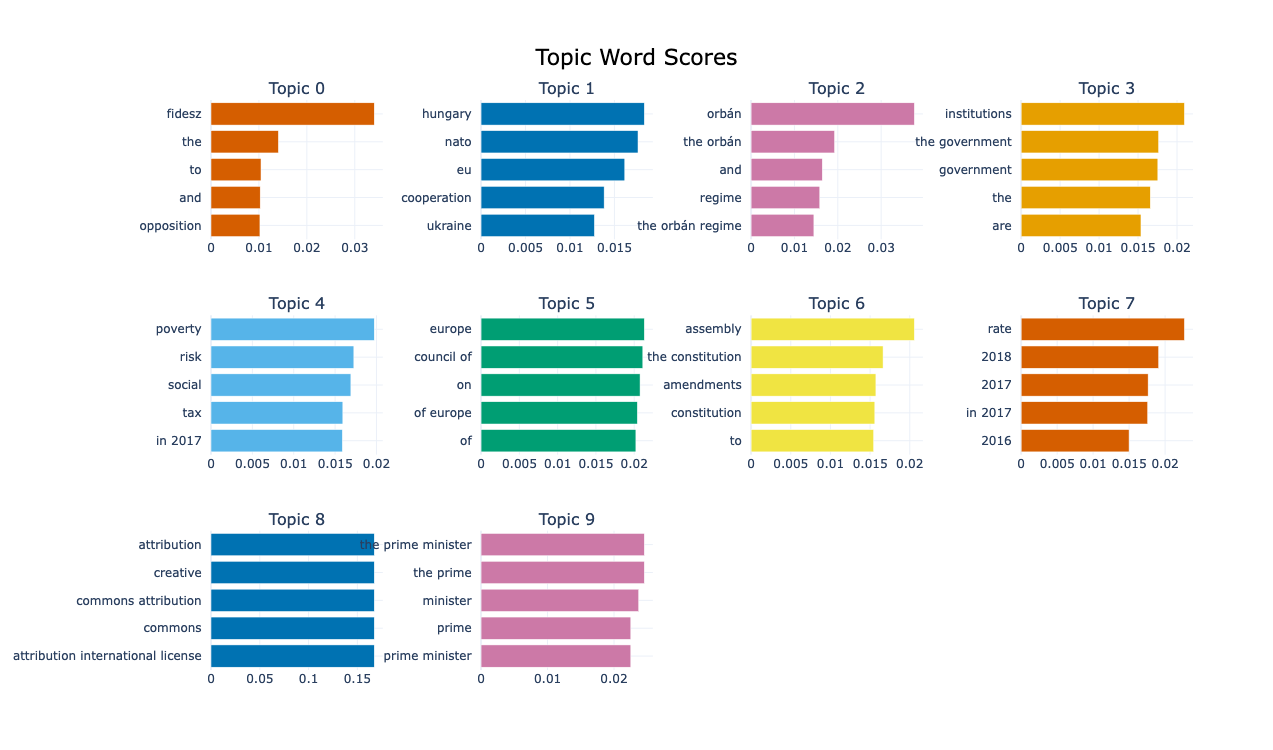

In [83]:
# visualize topic words/n_grams
model.visualize_barchart(top_n_topics=10)

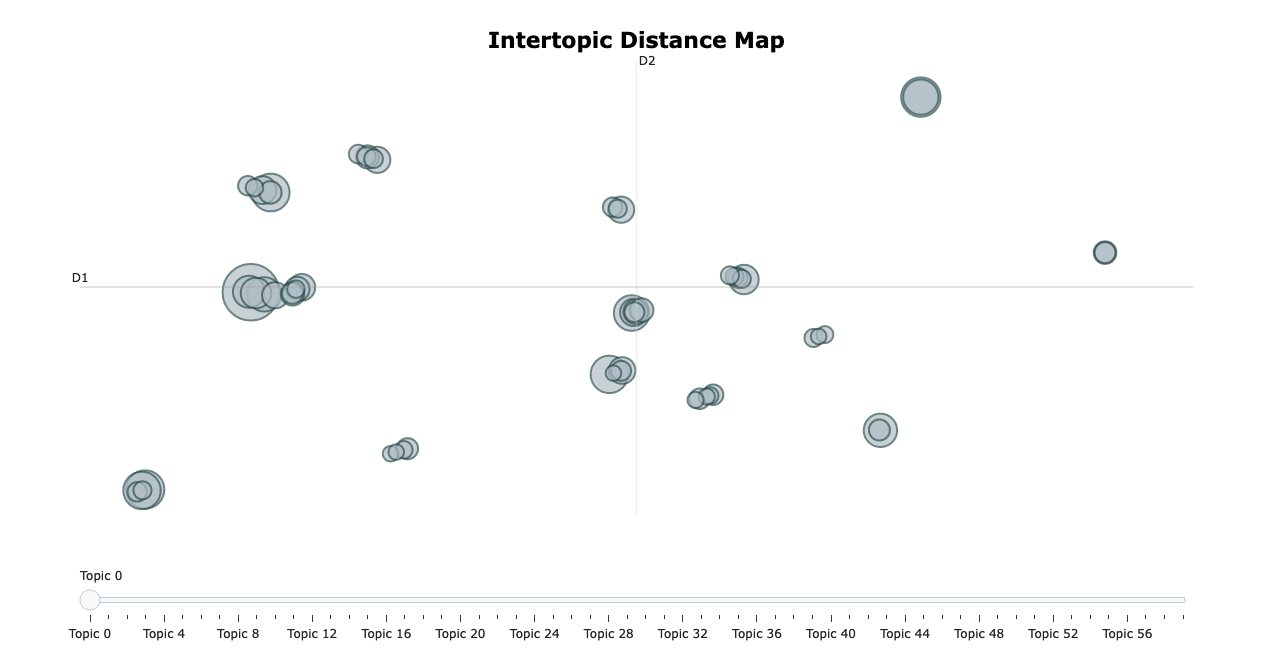

In [65]:
model.visualize_topics()

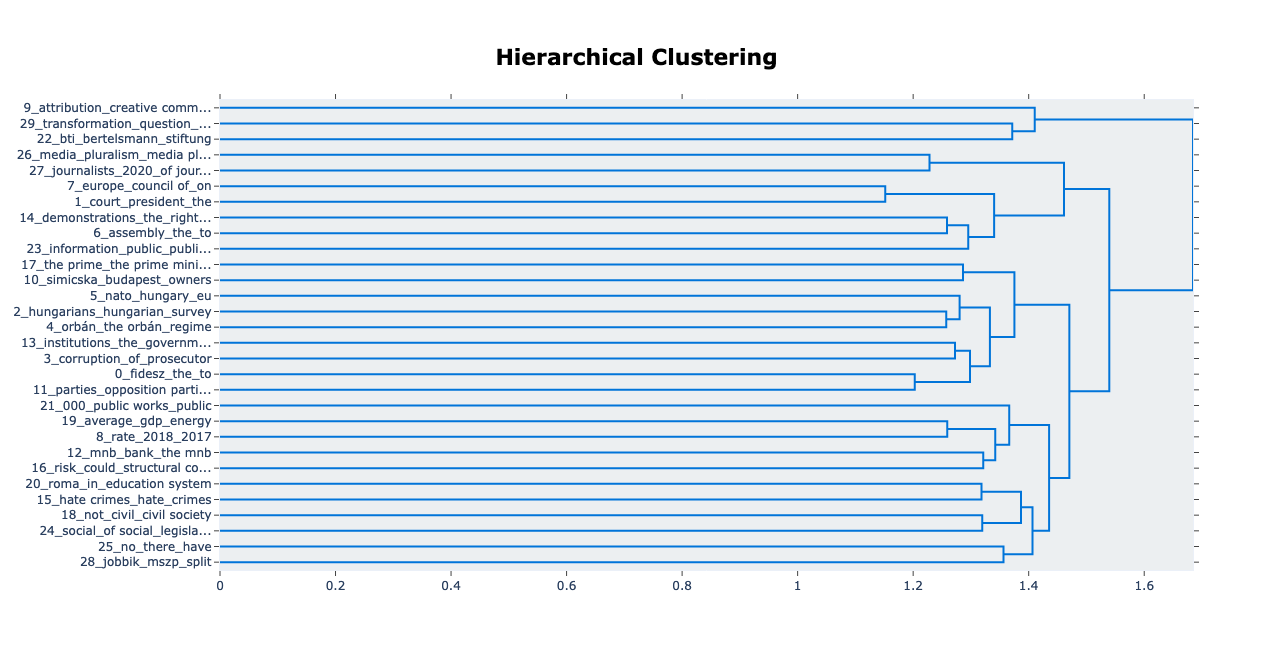

In [68]:
# visualize topic clusters
model.visualize_hierarchy(top_n_topics=30)

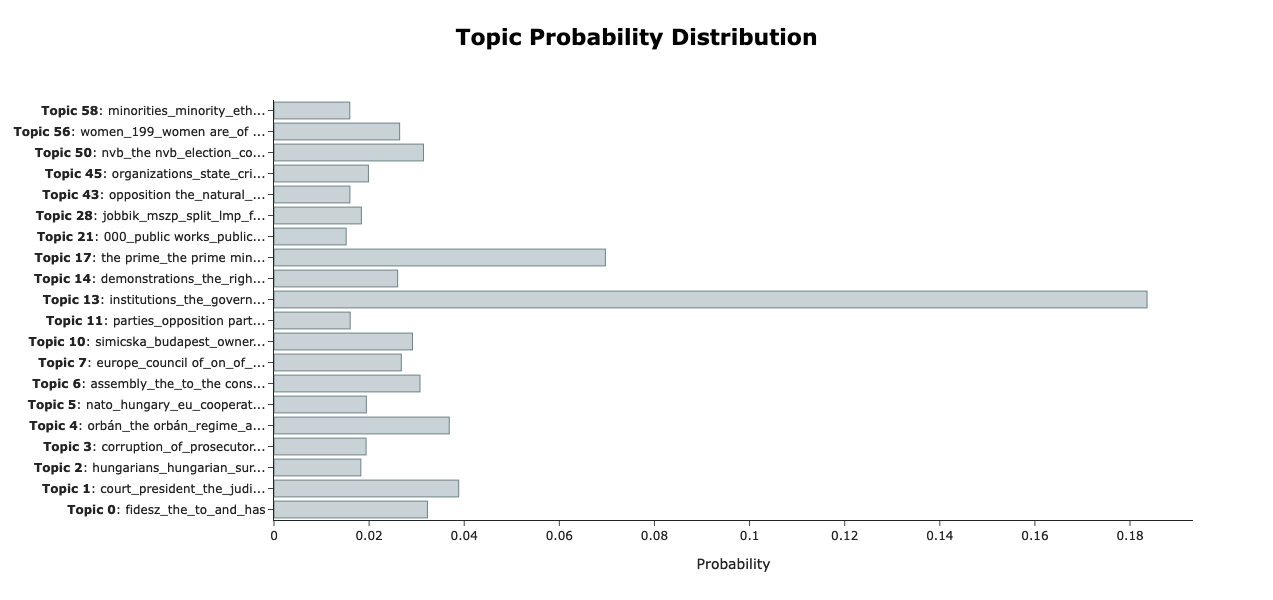

In [67]:
model.visualize_distribution(topic_distr[0])

In [74]:
# search for similar topics
topics = ["freedom of expression", "rule of law"]
for topic in topics:
    similar_topics, similarity = model.find_topics(topic, top_n = 3)
    most_similar = similar_topics[0]
    print(f"---{topic.upper()}---")
    print("Most Similar Topic Info: \n{}".format(model.get_topic(most_similar)))
    print("Similarity Score: {}".format(similarity[0]))

---FREEDOM OF EXPRESSION---
Most Similar Topic Info: 
[('assembly', 0.01875510695320094), ('the', 0.015253694063011186), ('to', 0.015174695055481744), ('the constitution', 0.015150296515569891), ('amendments', 0.014326162026887503), ('the government', 0.014255297759991467), ('constitution', 0.014207583953103247), ('freedom of assembly', 0.011833418564102012), ('of assembly', 0.011833418564102012), ('force', 0.011687371108135763)]
Similarity Score: 0.4349803049744244
---RULE OF LAW---
Most Similar Topic Info: 
[('private', 0.050283614733829474), ('private interests', 0.03267193861791902), ('sectors', 0.02844038314601005), ('interests', 0.027751220175375742), ('the ruling party', 0.025450589189436677), ('the ruling', 0.02490380982718094), ('ruling party', 0.02490380982718094), ('economic', 0.02439017582377617), ('ruling', 0.02382685521183224), ('governing elite and', 0.023263317643643734)]
Similarity Score: 0.5133467531414341


In [75]:
# save model
model.save(f"../data/{country}_{year}")

# loading model
# model=BERTopic.load("../data/file")